# Simulation using Concord

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
proj_name = "simulation_trajectory_predictunseen"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix


cpu


'Jun18-1506'

In [4]:
state_key = 'time'
batch_key = 'batch'
state_type = 'trajectory'
distribution = 'normal'
batch_distribution = 'normal'
leiden_key = 'leiden_no_noise'
batch_dispersion = [2.0,2.0,2.0]
batch_level = [10,10]

In [8]:
import numpy as np
from concord.simulation import (
    Simulation,
    SimConfig, TrajectoryConfig,   # ← note the different state config
    BatchConfig,
)

# ── batch side: identical to before ─────────────────────────────────────
rng = np.random.default_rng(42)
n_batches = 5
batch_level = 10 * rng.normal(1, 0.5, size=n_batches)   # centred at 10, σ≈5

batch_cfg = BatchConfig(
    n_batches     = n_batches,
    effect_type   = "batch_specific_features",
    distribution  = "normal",
    level         = batch_level.tolist(),      # ndarray → list
    dispersion    = 2.0,                      # same σ for every batch
    feature_frac  = 0.10,
    cell_proportion = [.2,.5,.3,.1,.4],  # batch-specific cell proportions
)

# ── global options (unchanged) ──────────────────────────────────────────
sim_cfg = SimConfig(
    n_cells = 1000,
    n_genes = 100,
    seed    = 42,
    non_neg = True,
    to_int  = True,
)

# ── state side: trajectory instead of clusters ─────────────────────────
state_cfg = TrajectoryConfig(
    # ► everything below corresponds 1-to-1 to the old call ◀︎
    distribution              = "normal",
    level                     = 10,           # state_level
    min_level                 = 0,
    dispersion                = 2.0,          # state_dispersion
    program_num               = 5,            # trajectory_program_num
    program_structure         = "linear_bidirectional",
    program_on_time_fraction  = 0.10,
    cell_block_size_ratio     = 0.60,         # trajectory_cell_block_size_ratio
    loop_to                   = None,         # trajectory_loop_to
)

# ── run ─────────────────────────────────────────────────────────────────
sim = Simulation(sim_cfg, state_cfg, batch_cfg)
adata, adata_state = sim.simulate_data()
adata.layers["counts"] = adata.X.copy()


In [9]:
adata.obs['train_use'] = True
adata.obs['train_use'][adata.obs[batch_key] == 'batch_3'] = False

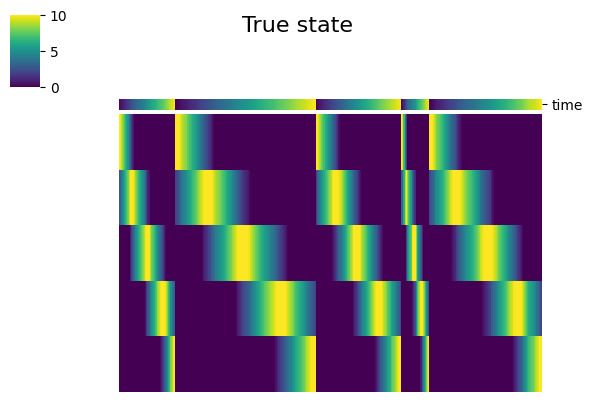

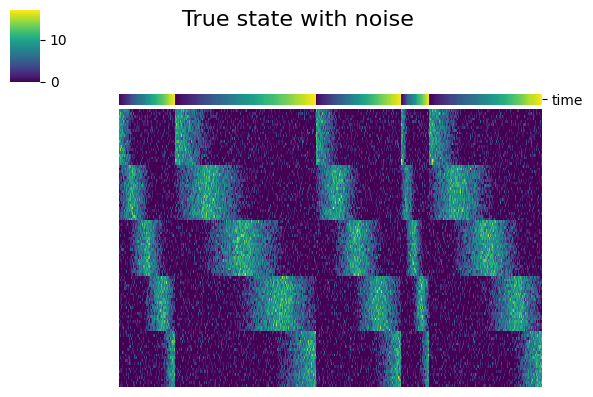

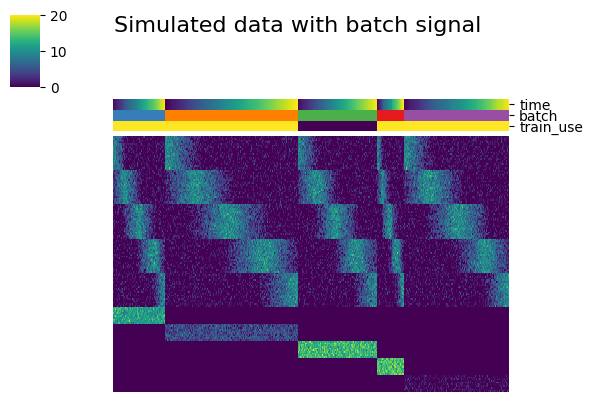

In [10]:
ccd.pl.heatmap_with_annotations(adata_state, val='no_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state', save_path=save_dir/f'true_state_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata_state, val='wt_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state with noise', save_path=save_dir/f'true_state_with_noise_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key, 'train_use'], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Simulated data with batch signal', save_path=save_dir/f'simulated_data_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)

### Concord

In [11]:
adata_train = adata[adata.obs['train_use']].copy()
adata_pred = adata[~adata.obs['train_use']].copy()

In [12]:
sc.tl.pca(adata_train, n_comps=50, svd_solver='arpack')

In [15]:
cur_ccd = ccd.Concord(adata=adata_train, 
                      input_feature=None, 
                      domain_key=batch_key, # key in adata.obs that contains the domain labels
                      seed=seed, # random seed
                      p_intra_knn=0.3,
                      p_intra_domain=.98,
                      clr_beta=0,
                      batch_size = 64,
                      n_epochs=10, # number of training epochs
                      knn_warmup_epochs=2,
                      sampler_emb = None,
                      verbose=False, # print training progress
                      device=device, # device to run on
                      save_dir=save_dir / 'model/' # directory to save model checkpoints
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord'

cur_ccd.fit_transform(output_key=output_key)

# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")

Concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


Epoch 1 Training: 100%|██████████| 17/17 [00:00<00:00, 393.79it/s, loss=3.56]
FAISS not found. Using sklearn for k-NN computation.
Epoch 9 Training: 100%|██████████| 17/17 [00:00<00:00, 435.12it/s, loss=3.54]


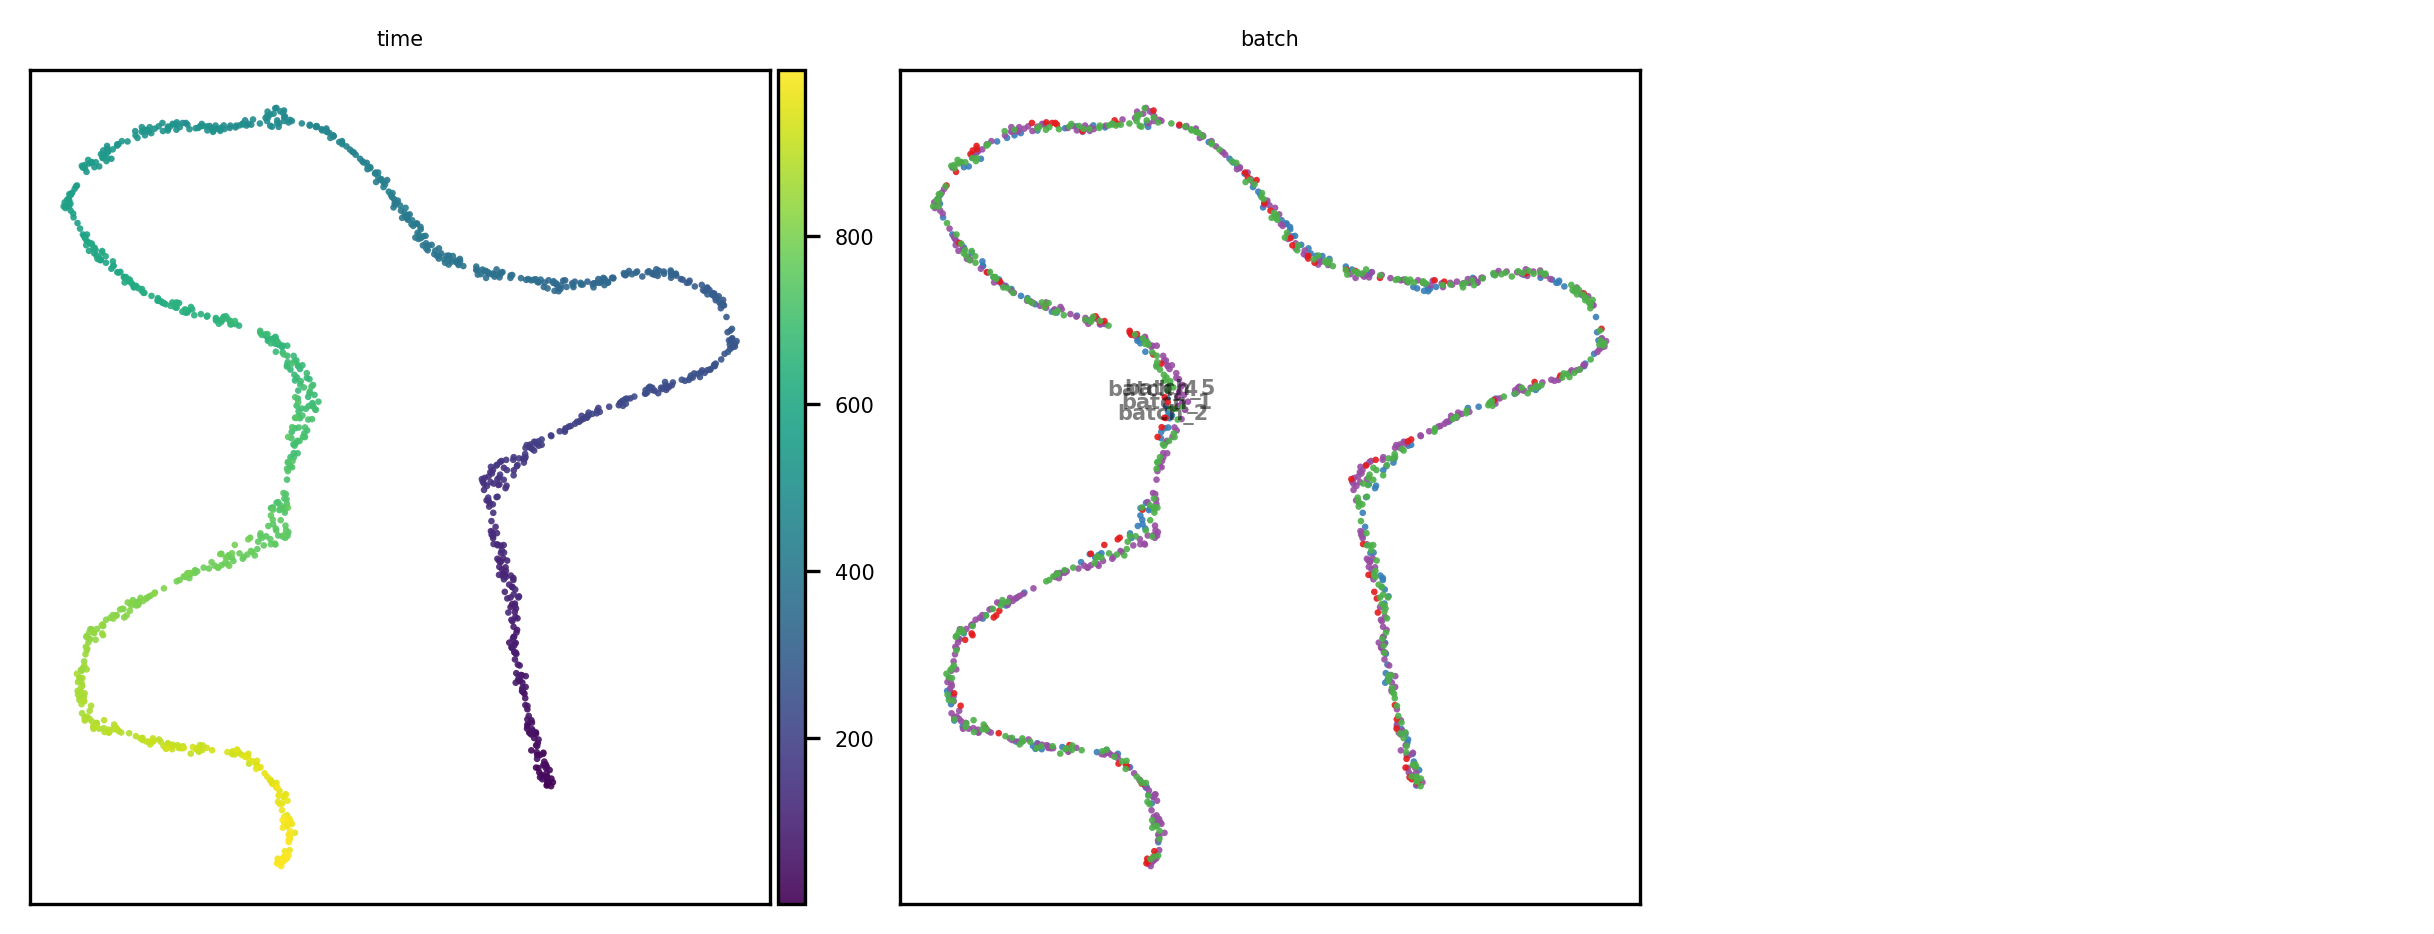

In [16]:
ccd.ul.run_umap(adata_train, source_key='Concord', result_key='Concord_UMAP_2D', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)

show_cols = [state_key, batch_key]
show_basis = 'Concord_UMAP_2D'   
ccd.pl.plot_embedding(
    adata_train, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    #pal = {'cluster':'Set1', 'batch':'Set2', 'leiden':'tab20'},
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)


In [17]:
adata_pred.obs['batch'] = adata_pred.obs['batch'].astype('category')
concord_model = ccd.Concord.load(model_dir=save_dir / 'model/',)

# 2. Predict on a new AnnData object with a simple, high-level method
# This method handles all the internal setup automatically.
results = concord_model.predict_adata(
    adata_pred,
    output_key=output_key,  # Key in adata.obsm to store the latent representation
    return_class_prob=True
)


In [18]:
adata_merge = adata_train.concatenate(adata_pred, batch_key='train_test', index_unique=None)

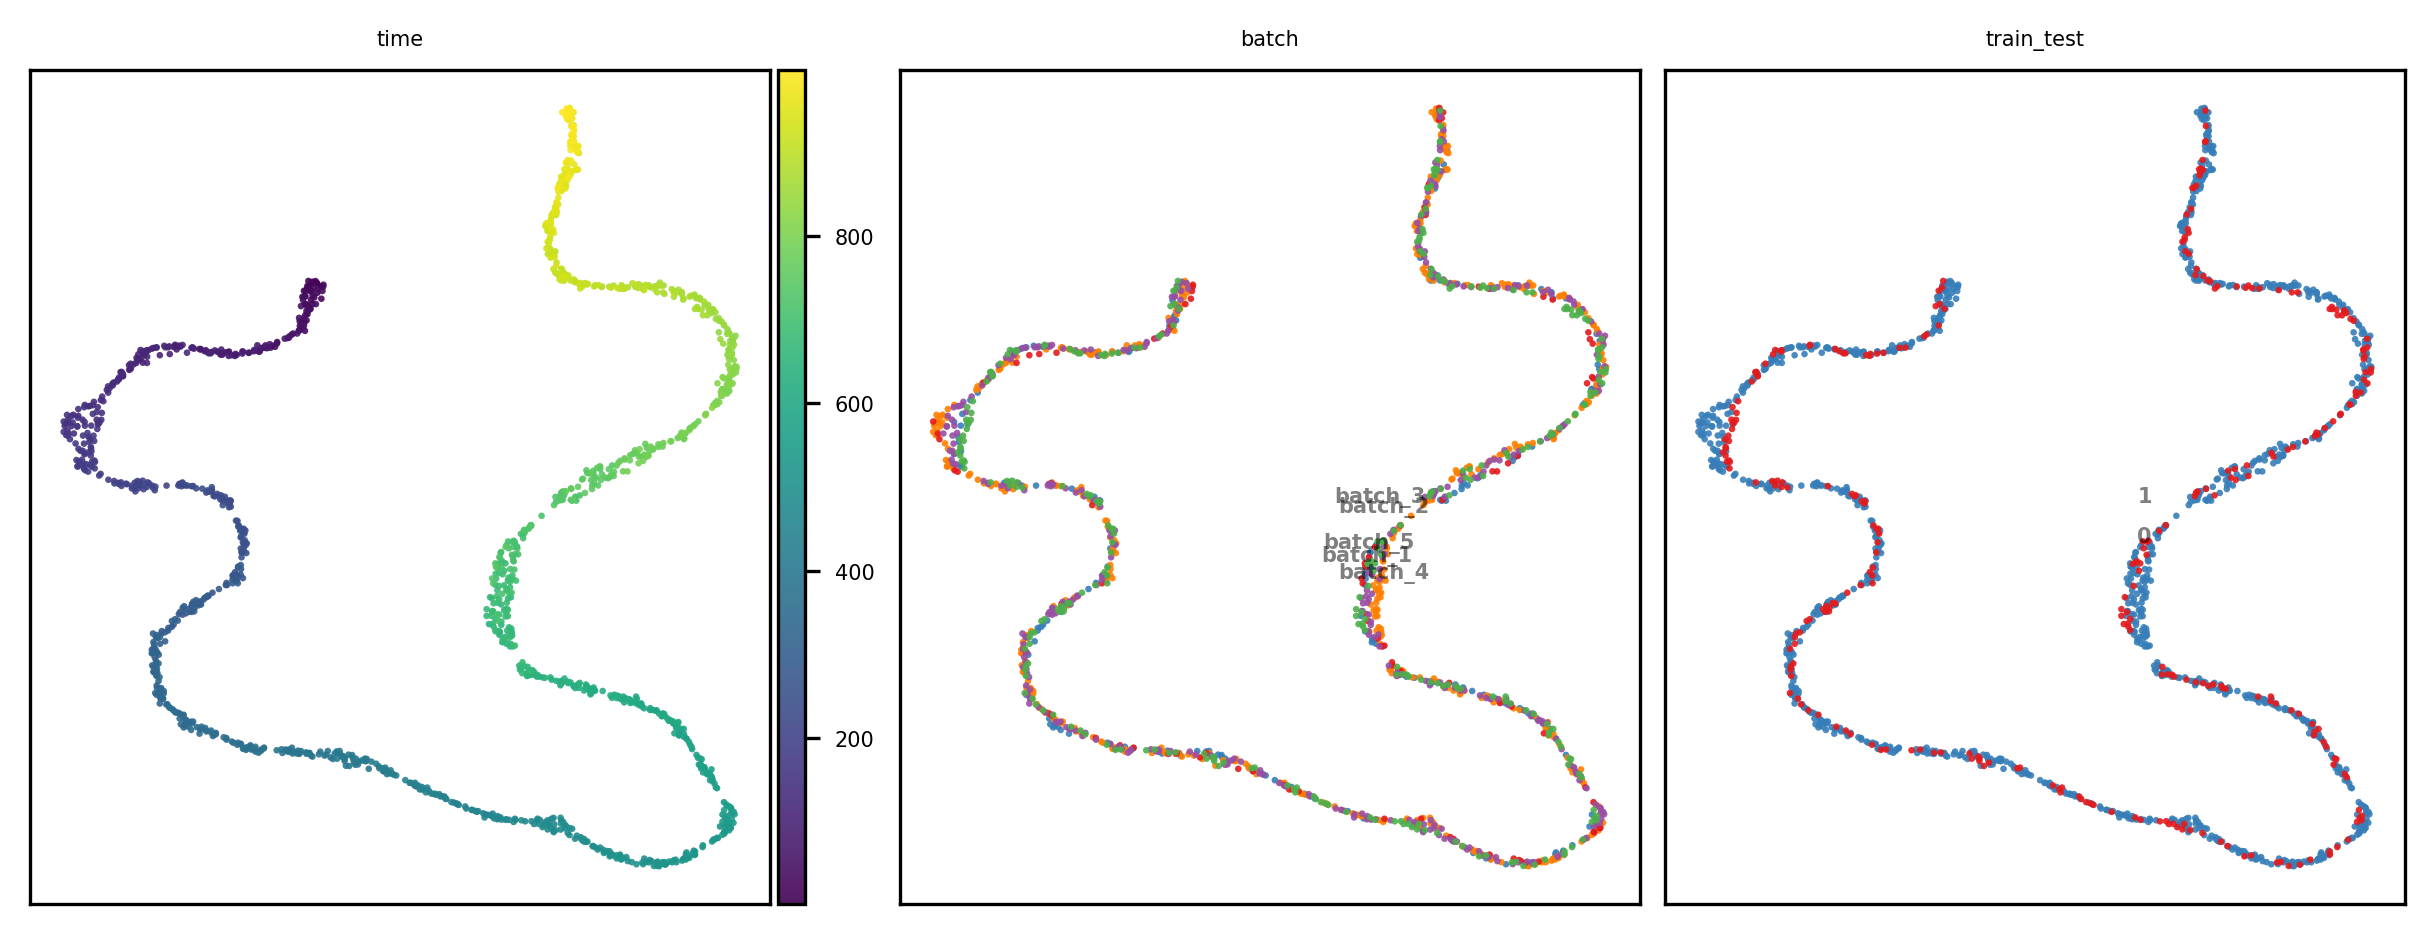

In [19]:
ccd.ul.run_umap(adata_merge, source_key='Concord', result_key='Concord_UMAP_2D', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)

show_cols = [state_key, batch_key, 'train_test']
show_basis = 'Concord_UMAP_2D'   
ccd.pl.plot_embedding(
    adata_merge, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    #pal = {'cluster':'Set1', 'batch':'Set2', 'leiden':'tab20'},
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)
